The goal is to explore the network sturctural differences when changing the train test split algorithm.

In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../'))

from dataset.data_loader import DataLoader, NodeType, remove_zero_playtime_edge
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import copy
from pprint import pprint

from evaluation.evaluation_harness import Evaluator
from models.common_neighbors_model import CommonNeighborsModel
from models.popularity_model import GamePopularityModel

ImportError: cannot import name 'CommonNeighborsModel' from 'models.common_neighbors_model' (/Users/jackson/Desktop/Classes/2024 Spring/ML Projects/ml-projects-project/dataset/../models/common_neighbors_model.py)

In [ ]:
def examine_networks(networks, data_loaders, network_names):
    output = {}
    assert len(networks) == len(network_names)
    def get_user_degrees(network):
        user_nodes = [node for node, data in network.nodes(data=True) if data['node_type'] == NodeType.USER]
        degrees = {node: val for (node, val) in network.degree()}
        return [degrees[user_node] for user_node in user_nodes]
    
    def get_game_degrees(network):
        game_nodes = [node for node, data in network.nodes(data=True) if data['node_type'] == NodeType.GAME]
        degrees = {node: val for (node, val) in network.degree()}
        return [degrees[game_node] for game_node in game_nodes]
    
    def get_user_closeness_centrality(network):
        user_nodes = [node for node, data in network.nodes(data=True) if data['node_type'] == NodeType.USER]
        centrality = nx.closeness_centrality(network)
        return [centrality[user_node] for user_node in user_nodes]
    
    def get_game_closeness_centrality(network):
        game_nodes = [node for node, data in network.nodes(data=True) if data['node_type'] == NodeType.GAME]
        centrality = nx.closeness_centrality(network)
        return [centrality[game_node] for game_node in game_nodes]
    
    def plot_histogram(values, log, bins, axis, title):
        axis.hist(values, bins=bins, color='skyblue', edgecolor='black')
        axis.set_title(title)
        axis.set_xlabel('Values')
        axis.set_ylabel('Frequency')
        if log:
            axis.set_yscale('log')
        
    def histogram_maker(function, title):
        fig, axes = plt.subplots(len(networks), figsize=(10, 8))
        fig.suptitle(title)
        fig.subplots_adjust(hspace=2)
        values_per_network = [function(network) for network in networks]
        min_val = min([v for values in values_per_network for v in values])
        max_val = max([v for values in values_per_network for v in values])
        bins = np.linspace(min_val, max_val, num=100)
        for ii, (values, network_name) in enumerate(zip(values_per_network, network_names)):
            plot_histogram(values, True, bins, axes[ii], f'{network_name}')
    
    print('Making degree histograms.')
    histogram_maker(get_user_degrees, 'User Degrees')
    histogram_maker(get_game_degrees, 'Game Degrees')

    # print('Making centrality histograms.')
    # histogram_maker(get_user_closeness_centrality, 'User Closeness Centrality')
    # histogram_maker(get_game_closeness_centrality, 'Game Closeness Centrality')

    def average_maker(function, title):
        values_per_network = [function(network) for network in networks]
        for values, network_name in zip(values_per_network, network_names):
            average = sum(values) / len(values)
            output[f'average_{title}_{network_name}'] = average

    print('Making average user degrees.')
    average_maker(get_user_degrees, 'user_degrees')
    average_maker(get_game_degrees, 'game_degrees')
    
    # def model_impact_maker(model):
    #     evaluator = Evaluator(top_N_games_to_eval = 500)
    #     for data_loader, split_name in zip(data_loaders, network_names[1:]):
    #         model.set_data_loader(data_loader)
    #         model.train()
    #         evaluator.reset(model)
    #         evaluator.plot_top_N_hit_percentage_percentiles(10)
    #         evaluator.plot_log_user_percentile_positional_error()
    #         evaluator.compute_mean_positional_error()
    #         evaluator.compute_top_N_hit_percentage(10)
    #         evaluator.plot_roc_curve()
    #         evaluator.compute_auc_roc()
    #         evaluator.plot_user_based_roc_curve()
    #         evaluator.compute_user_based_auc_roc()
    #         evaluator.save_metrics(f'train_test_split_experiment_model_metrics_{split_name}_{model.name()}', overwrite=True)

    # print('Making model impact.')
    # model_impact_maker(CommonNeighborsModel())
    # model_impact_maker(GamePopularityModel())

    return output

Making degree histograms.
Making average user degrees.
{'average_game_degrees_full_network': 20.556078459548786,
 'average_game_degrees_random_network': 16.444855582698665,
 'average_game_degrees_stratified_user_degree_network': 16.444855582698665,
 'average_game_degrees_stratified_user_network': 16.444855582698665,
 'average_user_degrees_full_network': 114.4398,
 'average_user_degrees_random_network': 91.5518,
 'average_user_degrees_stratified_user_degree_network': 91.5518,
 'average_user_degrees_stratified_user_network': 91.5518}


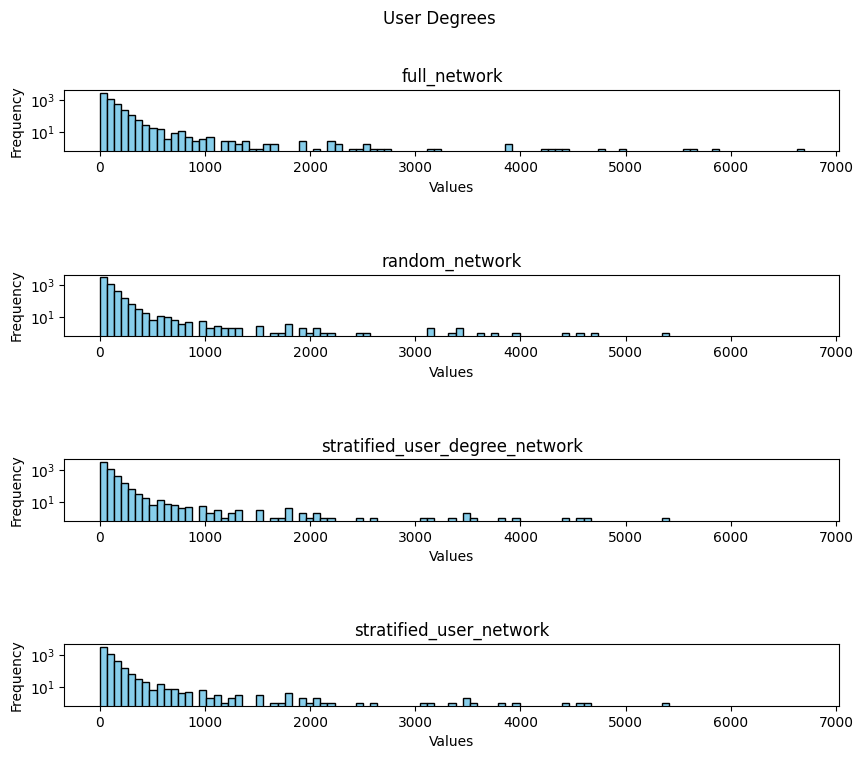

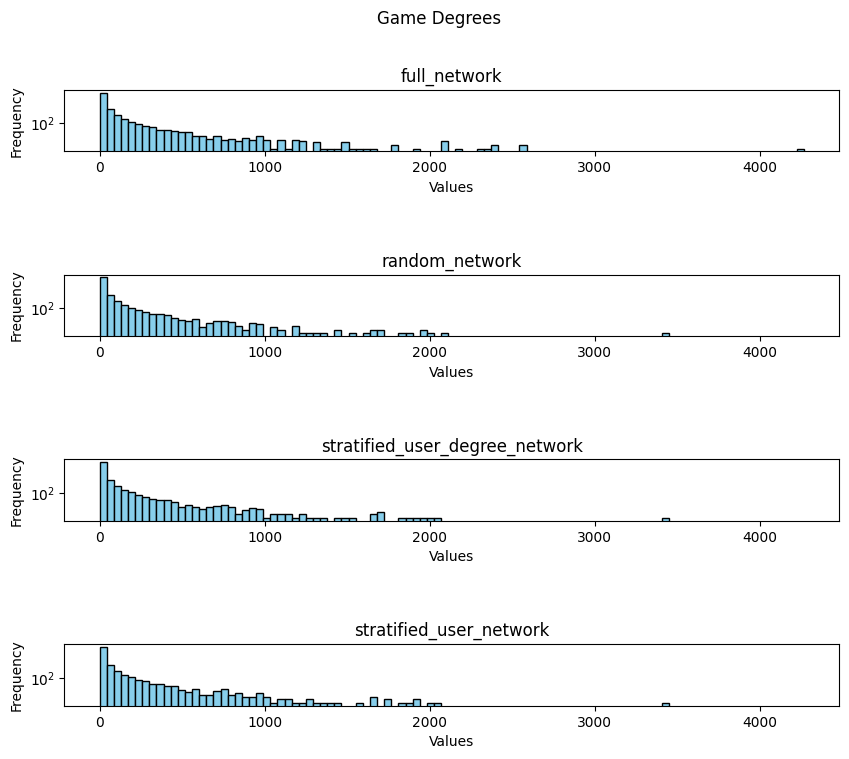

In [ ]:
random_data_loader = DataLoader(remove_edge_function=remove_zero_playtime_edge, user_game_edge_embeddings = ['playtime_forever'])
full_network = random_data_loader.get_full_network()

random_seed = 1

random_train_network, random_test_network = random_data_loader.load_random_train_test_network(full_network, seed=random_seed, train_percentage=0.8, test_percentage=0.2)

stratified_user_degree_data_loader = DataLoader()
stratified_user_degree_train_network, stratified_user_degree_test_network = stratified_user_degree_data_loader.load_stratified_user_degree_train_test_network(full_network, seed=random_seed, train_percentage=0.8, test_percentage=0.2)

stratified_user_data_loader = DataLoader()
stratified_user_train_network, stratified_user_test_network = stratified_user_data_loader.load_stratified_user_train_test_network(full_network, seed=random_seed, train_percentage=0.8, test_percentage=0.2)

output = examine_networks([full_network, random_train_network, stratified_user_degree_train_network, stratified_user_train_network], [random_data_loader, stratified_user_degree_data_loader, stratified_user_data_loader], ['full_network', 'random_network', 'stratified_user_degree_network', 'stratified_user_network'])
pprint(output)

In [ ]:
print(len([node for node, degree in full_network.degree() if degree == 1]))
print(len(list(nx.isolates(random_train_network))))
print(len(list(nx.isolates(stratified_user_degree_train_network))))
print(len(list(nx.isolates(stratified_user_train_network))))

[3490, 3520, 3570, 10120, 10250, 10260, 12660, 15160, 16100, 16110, 16180, 16200, 16500, 18430, 19080, 19320, 20200, 21500, 27200, 31800, 31810, 31820, 31840, 31850, 31860, 31880, 31890, 31900, 31930, 32000, 33550, 34630, 34640, 36900, 36910, 37210, 37230, 37300, 37310, 37320, 37330, 37960, 38000, 38080, 38090, 38100, 38110, 38120, 38130, 38150, 38180, 38190, 38450, 38460, 41400, 42000, 42200, 42220, 45420, 46700, 46710, 46730, 46830, 47110, 47120, 47130, 48150, 50970, 50980, 97110, 97120, 97130, 200150, 201000, 202670, 206020, 206060, 206230, 210230, 213350, 235520, 240360, 248270, 250070, 252390, 254820, 254860, 254920, 257260, 262510, 262630, 263180, 264080, 266270, 266980, 268930, 270830, 272920, 273030, 273890, 274700, 275330, 276240, 276300, 276380, 276430, 276460, 276750, 278850, 279420, 279460, 281560, 283490, 283600, 284910, 285670, 286220, 286790, 287740, 287960, 288000, 288610, 288690, 288830, 289200, 290060, 291370, 293160, 293980, 294730, 296650, 297470, 297570, 297590, 29